In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import seaborn as sns

In [5]:
df_final = pd.read_csv('datos_futures_B.csv')

In [6]:
df_final

,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,rolloff_var,flux_mean,flux_var,flatness_mean,flatness_var,zcr_mean,zcr_var,rms_mean,rms_var,is_ave
0,-457.182,-27.615,-7.902,87.386,-27.094,26.917,-2.890,10.692,2.795,-9.673,...,1.988157e+05,1.051,0.210,0.020,0.000,0.371,0.001,0.011,0.000,True
1,-451.401,-22.672,-15.683,93.317,-25.105,25.519,-4.547,15.306,-0.606,-9.735,...,9.035375e+04,0.990,0.093,0.020,0.000,0.360,0.001,0.006,0.000,True
2,-456.031,-24.423,-17.080,92.399,-24.114,19.734,-3.808,16.356,-0.961,-12.069,...,7.716837e+04,1.020,0.101,0.020,0.000,0.354,0.001,0.008,0.000,True
3,-458.103,-26.177,-10.296,92.317,-28.389,22.758,-1.497,10.952,-0.783,-6.988,...,1.290638e+05,1.010,0.099,0.023,0.000,0.360,0.001,0.008,0.000,True
4,-209.190,60.518,-10.017,24.976,-5.605,27.274,2.130,9.054,7.581,7.714,...,8.576387e+05,1.248,2.741,0.031,0.001,0.171,0.004,0.032,0.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15176,-321.788,120.534,24.356,26.009,18.251,20.076,1.067,1.495,-1.797,3.046,...,6.143957e+06,1.121,0.370,0.006,0.000,0.059,0.003,0.027,0.000,False
15177,-316.904,123.068,25.117,25.639,20.441,19.849,0.563,-0.355,-3.059,3.136,...,8.036128e+06,1.151,0.524,0.006,0.000,0.059,0.003,0.032,0.000,False
15178,-326.459,119.831,23.998,23.606,19.797,17.965,3.780,4.140,-2.249,4.520,...,7.076049e+06,1.142,0.572,0.007,0.000,0.053,0.002,0.027,0.000,False
15179,-342.516,90.252,1.332,29.101,7.894,25.831,-1.434,-8.623,3.808,-1.608,...,8.433179e+06,1.439,4.810,0.004,0.000,0.111,0.017,0.041,0.002,False


                Modelo  Precision  Recall  F1-Score     AUC
0        Random Forest     0.7571  0.9249    0.8326  0.9317
1              XGBoost     0.8525  0.9086    0.8796  0.9604
2  Logistic Regression     0.6299  0.7777    0.6960  0.7795
3                  SVM     0.8079  0.8923    0.8480  0.9320


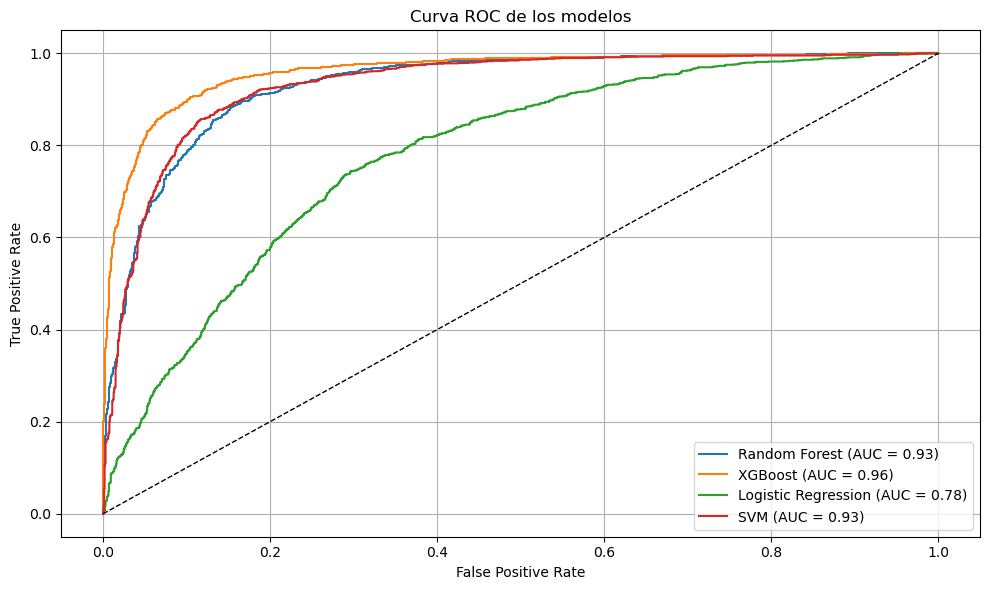

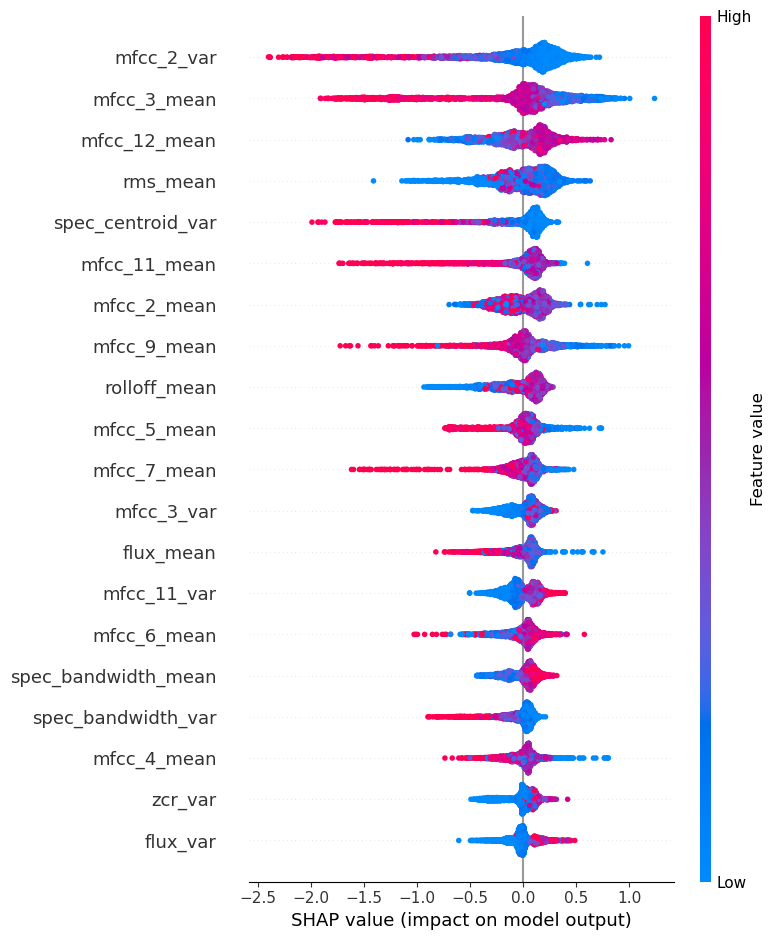

In [ ]:

df_final['is_ave'] = df_final['is_ave'].astype(bool).astype(int)
X = df_final.drop(columns=['is_ave'])
y = df_final['is_ave']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)  # type: ignore

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal) # type: ignore
X_test_scaled = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,                 
        min_samples_leaf=5,          
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        reg_alpha=0.5,               # L1 regularización
        reg_lambda=1.0,              # L2 regularización
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        penalty='l2',                # L2 regularización (ridge)
        C=0.5,                       # menor C => más regularización
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        C=0.5,                       # menor C => más margen, menos sobreajuste
        probability=True,
        random_state=42
    )
}

resultados = []

def evaluar(nombre, y_test, y_pred, y_proba):
    resultados.append({
        'Modelo': nombre,
        'Precision': round(float(precision_score(y_test, y_pred)), 4),
        'Recall': round(float(recall_score(y_test, y_pred)), 4),
        'F1-Score': round(float(f1_score(y_test, y_pred)), 4),
        'AUC': round(float(roc_auc_score(y_test, y_proba)), 4)
    })

for nombre, modelo in models.items():
    if nombre in ['Logistic Regression', 'SVM']:
        modelo.fit(X_train_scaled, y_train_bal)
        y_pred = modelo.predict(X_test_scaled)
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train_bal, y_train_bal)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        
    evaluar(nombre, y_test, y_pred, y_proba)

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for nombre, modelo in models.items():
    if nombre in ['Logistic Regression', 'SVM']:
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = modelo.predict_proba(X_test)[:, 1]
        
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})")

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC de los modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Para Random Forest
importances_rf = models['Random Forest'].feature_importances_
# Para XGBoost
importances_xgb = models['XGBoost'].feature_importances_

# Explicador de SHAP para XGBoost
explainer = shap.TreeExplainer(models['Random Forest'])
shap_values = explainer.shap_values(X_test)

# Gráfico de resumen de importancia global
# shap.summary_plot(shap_values, X_test, plot_type="bar")


shap.summary_plot(shap_values, X_test)

In [10]:
from scipy.special import expit  # sigmoid para SVM
import pandas as pd

# Cargar los features del nuevo audio
df_new = pd.read_csv('ave.csv')  
df_new_scaled = scaler.transform(df_new)  


def decode_label(pred):
    return ['Ave' if p > 0.7 else 'No Ave' for p in pred]


pred_rf = models['Random Forest'].predict(df_new)
proba_rf = models['Random Forest'].predict_proba(df_new)[:, 1]


pred_xgb = models['XGBoost'].predict(df_new)
proba_xgb = models['XGBoost'].predict_proba(df_new)[:, 1]


pred_log = models['Logistic Regression'].predict(df_new_scaled)
proba_log = models['Logistic Regression'].predict_proba(df_new_scaled)[:, 1]


pred_svm = models['SVM'].predict(df_new_scaled)
proba_svm = expit(models['SVM'].decision_function(df_new_scaled))

results_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM'],
    'Predicción': decode_label([pred_rf[0], pred_xgb[0], pred_log[0], pred_svm[0]]),
    'Probabilidad Ave': [
        round(proba_rf[0], 3),
        round(proba_xgb[0], 3),
        round(proba_log[0], 3),
        round(proba_svm[0], 3)
    ]
})

print(results_df)

                Modelo Predicción  Probabilidad Ave
0        Random Forest        Ave             0.654
1              XGBoost        Ave             0.955
2  Logistic Regression        Ave             0.822
3                  SVM        Ave             0.573
